# Permutation vs. Bootstrapping: An example

A new coffee shop on campus just opened, and you and your classmates from PSYC 201B have been frequenting it a lot! The new coffee shop is marketed as being consumer-focused, and that the coffee price changes almost every day based on the market price of coffee beans. The owner claims that this way they pass the maximum savings to consumers. However, one day you overheard the owner saying that his favorite color is purple, and that his least favorite color is orange. This got you and your classmates wondering whether the patrons' shirt color might affect how much the owner charges them. You decide to investigate, and over a few days, you and your classmates wear either an orange or a purple shirt to buy 2 coffees at the coffee shop and track their prices.

In this notebook, you will investigate whether there is a difference between coffee prices when purchased by someone wearing a purple shirt vs. an orange shirt.

## Inputting data

Work with your classmates to input your data into a [Google Sheets](https://docs.google.com/spreadsheets/d/17-PSvhuGwyX7mehxxJu4kku_DBznBbEYjdrzmnNHXgE/edit?gid=0#gid=0), and then download it as a .csv file (you can name this file `coffee.csv`). Even though each person bought 2 coffees at the store, you can imagine that these 2 purchases are independent of one another (i.e., you don't have to take into account the fact that each person contributed 2 data points). 

Recommendation: your data should have 1 row per each coffee purchased. Consider having 2 columns `shirt_color` and `coffee_price`.

## Setting goals / research questions

Before running any analysis, it is useful to think about what questions you want to answer. Our main research questions for this study are: 
1. Is the owner's preference for purple reflected in his coffee price, i.e., is there a significant difference between coffee prices when purchased when wearing a purple shirt vs. an orange shirt? 
2. What is the range of coffee prices you should expect when wearing an purple shirt? When wearing an orange shirt? 

## Is there a significant difference? Permutation test! 

In [33]:
# Numpy - arrays and basic stats
import numpy as np

# Polars - dataframes
import polars as pl
from polars import col

# Statistical plots
import seaborn as sns

# Simple plots
import matplotlib.pyplot as plt

# Permutation test
from scipy.stats import permutation_test

# Bootstrapping
from scipy.stats import bootstrap

# Setup some default styles for plots
plt.style.use('ggplot')
sns.set_style('white')

import polars.selectors as cs

In [34]:
#Import your csv file
#hint: your df should have 1 row for each observation!
#hint: consider these column names: `shirt_color`, `coffee_price`
df = pl.read_csv('coffee.csv')
df

shirt_color,coffee_price
str,f64
"""orange""",7.9
"""orange""",3.24
"""orange""",2.68
"""orange""",5.0
"""purple""",5.17
"""purple""",7.23
"""purple""",9.12
"""purple""",8.14


Let's plot the data first to see what we're working with...

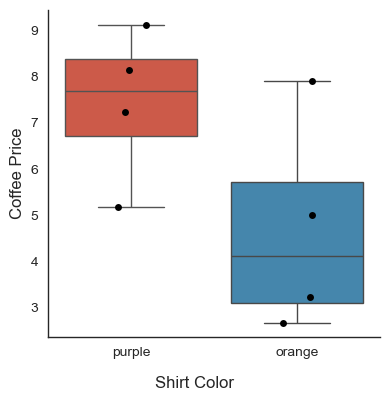

In [35]:
grid = sns.FacetGrid(
    data=df,
    hue='shirt_color',
    hue_order=['purple','orange'],
    height=4
)

grid.map(sns.boxplot,'shirt_color','coffee_price', order=['purple','orange']);

grid.map(sns.stripplot,'shirt_color','coffee_price', color='black', order=['purple','orange']);

# Customize labels
grid.set_axis_labels('', 'Coffee Price');
grid.figure.supxlabel('Shirt Color');
grid.set_titles('{col_name}');

What is the difference between the means of coffee prices purchased by people wearing purple vs. orange shirt? 

In [36]:
orange_shirts = df.filter(
    col('shirt_color') == 'orange')['coffee_price'].to_numpy()

purple_shirts = df.filter(
    col('shirt_color') == 'purple')['coffee_price'].to_numpy()

print(orange_shirts)
print(purple_shirts)

[7.9  3.24 2.68 5.  ]
[5.17 7.23 9.12 8.14]


In [38]:
def diff_of_means(purple_shirts, orange_shirts):
    return np.mean(purple_shirts) - np.mean(orange_shirts)

observed_mean_diff = diff_of_means(purple_shirts, orange_shirts)
print(observed_mean_diff)

2.71


Is this difference significant?

In [91]:
result = permutation_test(
    (purple_shirts, orange_shirts),  # <- tuple of the arrays we created earlier
    diff_of_means,            # <- function we just defined
    permutation_type='independent', # <- how we want the permutation to be done
    alternative='less' # <- because we have a hypothesis that the coffee price is lower for purple shirt-wearers compared to orange shirt-wearers
)
result?

Type:        PermutationTestResult
String form:
PermutationTestResult(statistic=np.float64(2.71), pvalue=np.float64(0.9571428571428572), null_dis <...>   0.63 ,  0.35 , -0.65 ,  0.51 ,  0.23 ,
           -2.1  , -1.14 ,  0.02 , -0.26 , -2.59 , -2.71 ]))
File:        /opt/anaconda3/envs/201b/lib/python3.12/site-packages/scipy/stats/_resampling.py
Docstring:  
Result object returned by `scipy.stats.permutation_test`.

Attributes
----------
statistic : float or ndarray
    The observed test statistic of the data.
pvalue : float or ndarray
    The p-value for the given alternative.
null_distribution : ndarray
    The values of the test statistic generated under the null
    hypothesis.

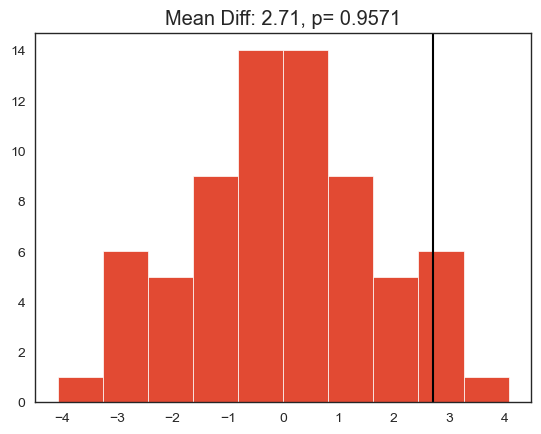

In [92]:
plt.hist(result.null_distribution);

# Vertical line at our observed mean difference
plt.axvline(result.statistic, color='black');

# Title with stats using f-strings
plt.title(f"Mean Diff: {result.statistic:.2f}, p= {result.pvalue:.4f}");

What does `permutation_test` do under the hood?

We are testing how likely we'll get the observed difference (or larger) if there is truly no difference between purple vs. orange shirts. 

To do so, we shuffle all the data we have, and just randomly assign each data point as `orange` or `purple`. If there is truly no difference between purple vs. orange shirts, then randomly assigning data points to shirt colors shouldn't make it less likely to get the difference we observed. 

In [93]:
both_shirts = np.concatenate((purple_shirts, orange_shirts))
shuffled_shirts = np.random.permutation(both_shirts)

orange_shirts_shuffled = shuffled_shirts[: len(orange_shirts)]
purple_shirts_shuffled = shuffled_shirts[len(purple_shirts) :]

shuffled_diff = diff_of_means(purple_shirts_shuffled, orange_shirts_shuffled)

print(f"Shuffled difference: {shuffled_diff:.2f}")

Shuffled difference: 2.02


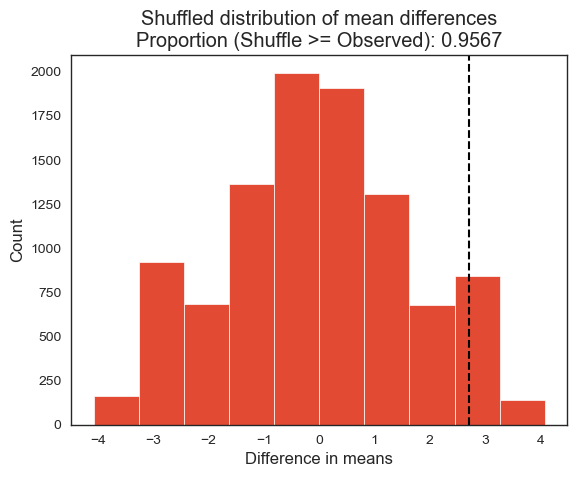

In [94]:
permuted_diffs = []
for _ in range(10000):

    # Shuffle the combined data

    shuffled_shirts = np.random.permutation(np.concatenate((purple_shirts, orange_shirts)))

    # Split into two groups
    orange_shirts_shuffled = shuffled_shirts[: len(orange_shirts)]
    purple_shirts_shuffled = shuffled_shirts[len(purple_shirts) :]


    # Calculate the difference in means for this permutation
    shuffled_diff = diff_of_means(purple_shirts_shuffled, orange_shirts_shuffled)

    # Store it
    permuted_diffs.append(shuffled_diff)

permuted_diffs = np.array(permuted_diffs)

permuted_p = np.mean(permuted_diffs <= observed_mean_diff)

plt.hist(permuted_diffs);
plt.axvline(observed_mean_diff, color="black", linestyle="--");
plt.xlabel("Difference in means");
plt.ylabel("Count");
plt.title(f"Shuffled distribution of mean differences\nProportion (Shuffle >= Observed): {permuted_p}");

## What is the range of mean coffee prices should we expect if we purchase coffee wearing an orange shirt? Bootstrapping!

We can use the existing distribution of prices for orange shirts, and pretend that we keep running multiple experiments where we purchase coffee while wearing orange shirts and get coffee prices from this distribution. If we then calculate the mean of coffee prices for each 'experiment', this builds up a distribution of mean coffee prices when wearing an orange shirt. 

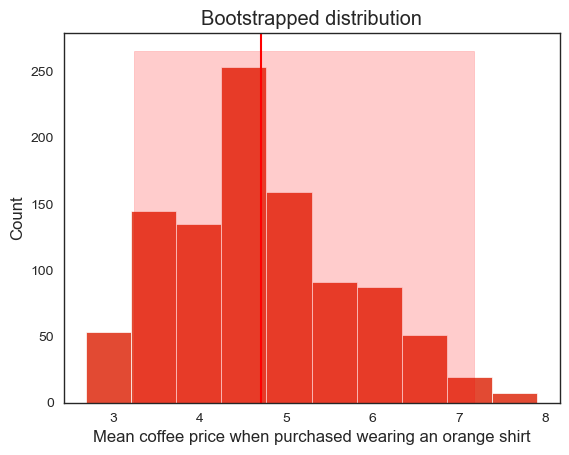

In [96]:
# bootstrap() expects a *sequence* or arrays as input
# since only have one array, we can turn it into a sequence
# by wrapping it in a tuple

data = (orange_shirts,)  # wrap it in a tuple

result = bootstrap(
    data, statistic=np.mean, n_resamples=1000, confidence_level=0.95, method="BCa"
)

# Calculate the mean
scipy_boot_mean = result.bootstrap_distribution.mean()

# Plot it
plt.hist(result.bootstrap_distribution)

# Add the mean
plt.axvline(scipy_boot_mean, color="red", label="Mean")

# Create error band for CIs
x_min, x_max = result.confidence_interval

y_min, y_max = plt.gca().get_ylim()  # Get the y-axis limits of the histogram

plt.fill_betweenx(
    [y_min, y_max], x_min, x_max, color="red", alpha=0.2
)

plt.xlabel("Mean coffee price when purchased wearing an orange shirt")
plt.ylabel("Count")
plt.title("Bootstrapped distribution");

What does `bootstrap` do under the hood?

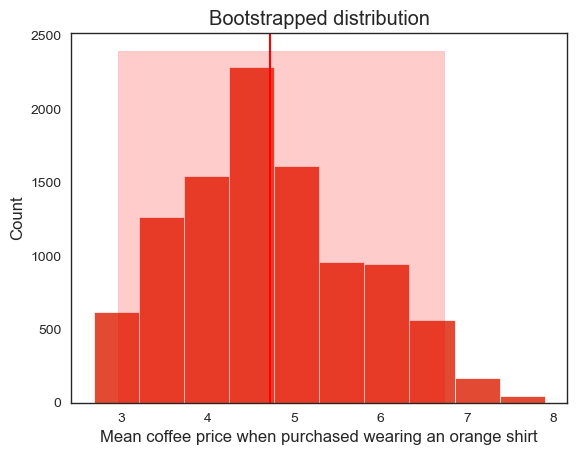

In [ ]:
boot_means = []
for i in range(10000):

    #repeatedly select from the data points of orange shirt-wearers
    this_boot_mean = np.random.choice(
        orange_shirts, size=len(orange_shirts), replace=True
    ).mean()

    boot_means.append(this_boot_mean)

# Convert it to numpy array to make it easier to work with
boot_means = np.array(boot_means)

# Calculate the mean or all means!
boot_mean = boot_means.mean(),

# Plot the means from each 'experiment'
plt.hist(boot_means)

# Add the mean of all the means!
plt.axvline(boot_mean, color="red", label="Mean")

# Create error band for confidence interval
boot_mean_ci = np.percentile(boot_means, [2.5, 97.5])
x_min, x_max = boot_mean_ci[0], boot_mean_ci[1]
y_min, y_max = plt.gca().get_ylim()  # Get the y-axis limits of the histogram

plt.fill_betweenx(
    [y_min, y_max], x_min, x_max, color="red", alpha=0.2
)

plt.xlabel("Mean coffee price when purchased wearing an orange shirt")
plt.ylabel("Count")
plt.title("Bootstrapped distribution");